# Anomaly Detection

In this notebook, we will examine applications for Anomaly Detection on different real word datasets. We use some of the Anomaly Detection algorithms.

**Used Anomaly Detection Algorithms in This Notebook**:
- Isolation Forest
- Local Outlier Factor
- XGBoost
- CatBoost
- LightGBM

Also, we will those methods with subsampling.

**Used Dataset in This Notebook**
- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

# Preparation

First of all, we need to install catboost and xgboost libraries to use them.

In [ ]:
%%capture
!pip install catboost
!pip install xgboost

Import libraries, set the seed and suppress all warnings.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score
)
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import Pool, CatBoostClassifier, cv

SEED = 2112
import warnings
warnings.filterwarnings('ignore')

Load pandas dataframe and show.

In [ ]:
df = pd.read_csv("../data/creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As you can see, there is a imblancing between classes. The dataset is highky imblanaced. 

- Class 0 (normal): 284315 samples
- Class 1 (anomaly): 492 samples.    

In [ ]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Implement our confusion matrix visualizer. 

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d",cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
  plt.xlabel("Prediction")
  plt.ylabel("Ground Truth")

# Isolation Forest

<img src="images/1.png" height=600 width=600>

The Isolation Forest “isolates” observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. iForest utilizes no distance or density measures to detect anomalies. 

solation means ‘separating an instance from the rest of the instances’. Since anomalies are “few and different” and therefore they are more susceptible to isolation. This random partitioning produces noticeable shorter paths for anomalies:
- The fewer instances of anomalies result in a smaller number of partitions – shorter paths in a tree structure
- Instances with distinguishable attribute-values are more likely to be separated in early partitioning. 

Hence, when a forest of random trees collectively produce shorter path lengths for some particular points, then they are highly likely to be anomalies.


Split our dataset as train - test.

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


Replace anomalies as -1, normal samples as 1.

In [ ]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

Create X_train and y_train, X_test and y_test.

In [ ]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Initialize our Isolation Forest.

- max_samples: The number of samples to draw from X to train each base estimator.
- random_state: the seed.
- contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples.
- n_estimators: The number of base estimators in the ensemble.

In [ ]:
clfIF = IsolationForest(
    max_samples = 0.25, 
    random_state = SEED, 
    contamination = 0.05,#
    n_estimators = 30, 
    n_jobs =- 1
)

Fit our model. Normally, Isolation Forest is an unsupervised learning algorithm. Passing y_train does not make sense. However, sklearn presents this argument due to API consistency by convention.

In [ ]:
clfIF.fit(X_train, y_train)

IsolationForest(contamination=0.05, max_samples=0.25, n_estimators=30,
                n_jobs=-1, random_state=2112)

Let's predict $\hat{y}$ regard to X_test.

In [ ]:
y_pred_test = clfIF.predict(X_test)

Use ```classification_report``` to see all metrics.

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.03      0.84      0.06       173
           1       1.00      0.95      0.97     93814

    accuracy                           0.95     93987
   macro avg       0.52      0.90      0.52     93987
weighted avg       1.00      0.95      0.97     93987



In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

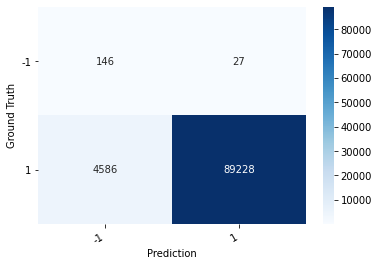

In [ ]:
show_confusion_matrix(df_cm)

# Isolation Forest With Subsampling

What about subsampling on dominant class? Will this helpful for us? Let's see.

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


Replace anomalies as -1, normal samples as 1.

In [ ]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)
print(train_df[train_df["Class"] == -1].shape[0], train_df[train_df["Class"] == 1].shape[0])

319 190501


Let's subsample normal class (1) with proportion of $\lceil\frac{len(data)}{35}\rceil$.

In [ ]:
n_samples = train_df[train_df["Class"] == 1].shape[0] // 35
anomalies = train_df[train_df["Class"] == -1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 1].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == -1].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

319 5442


Now, we have 5442 normal and 319 anomaly in our train dataset. Lastly, we will do the same things. Initialize the estimator, fit it, then predict and evaluate.

In [ ]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [ ]:
clfIF = IsolationForest(
    max_samples = 0.25,
    contamination = 0.25,
    random_state=SEED, 
    n_estimators=30, 
    n_jobs=-1)

In [ ]:
clfIF.fit(X_train, y_train)

IsolationForest(contamination=0.25, max_samples=0.25, n_estimators=30,
                n_jobs=-1, random_state=2112)

In [ ]:
y_pred_test = clfIF.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.01      0.89      0.02       173
           1       1.00      0.79      0.88     93814

    accuracy                           0.79     93987
   macro avg       0.50      0.84      0.45     93987
weighted avg       1.00      0.79      0.88     93987



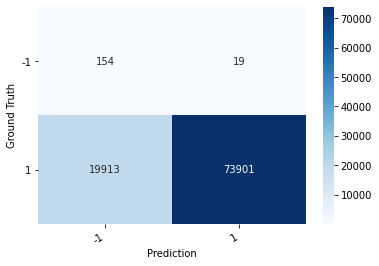

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)
show_confusion_matrix(df_cm)

# Local Outlier Factor

<img src="images/3.png" height=250 width=250>

The local outlier factor is based on a concept of a local density, where locality is given by k nearest neighbors, whose distance is used to estimate the density. 

By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.

There are such terms that acts as a building blocks of Local Outlier Factor.

**K-distance** is based on neighborhood style distance calculation. The distances of a point A to its neighbors are calculated, and if these distances are ordered from smallest to largest, the kth distance gives us the k-distance.

**Reachability distance:** Let $k$ be a natural number. The reachability distance of object $p$ with respect to object o is defined as:

$$reach-distk(p, o) = max\{k-distance(o), d(p,o)\}$$

Intuitively, the local reachability density of an object p is the inverse of the average reachability distance based on the MinPts-nearest neighbors of p. 

$$lrd_{MinPts}(p) = \frac{1}{\frac{\sum_{o \in N_{MinPts}(p)}  reach\_dist_{MinPts}(o)}{\mid N_{MinPts}(p)\mid}}$$

The outlier factor of object $p$ captures the degree to which we call $p$ an outlier. It is the average of the ratio of the local reachability density of $p$ and those of $p$’s MinPts-nearest neighbors. LOF generates a score for each point. A value below 1 indicates a denser region, while values significantly greater than 1 indicate outliers.

$$LOF_{MinPts}(p) = \frac{ \sum_{o \in N_{MinPts}(p)} \frac{lrd_{MinPts}(o)}{lrd_{MinPts}(p)}}{\mid N_{MinPts}(p)\mid}$$


<img src="images/2.jpg" height=400 width=400>

Now, we will do the same things before.

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [ ]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

In [ ]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Initialize the Local Outlier Factor algorithm.

- n_neighbors: Number of neighbors to use by default for kneighbors queries. If n_neighbors is larger than the number of samples provided, all samples will be used.
- algorithm: Algorithm used to compute the nearest neighbors:
- metric: The metric is used for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
- contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. When fitting this is used to define the threshold on the scores of the samples.

In [ ]:
clfLOF = LocalOutlierFactor(
    n_neighbors=7, 
    metric='l1', 
    algorithm='auto', 
    contamination=0.05, 
    n_jobs=-1,
)

Fit the model.

In [ ]:
clfLOF.fit(X_train, y_train)

Let's predict $\hat{y}$ regard to X_test.

In [ ]:
y_pred_test = clfLOF.fit_predict(X_test)

Use ```classification_report``` to see all metrics.

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.02      0.65      0.05       173
           1       1.00      0.95      0.97     93814

    accuracy                           0.95     93987
   macro avg       0.51      0.80      0.51     93987
weighted avg       1.00      0.95      0.97     93987



In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

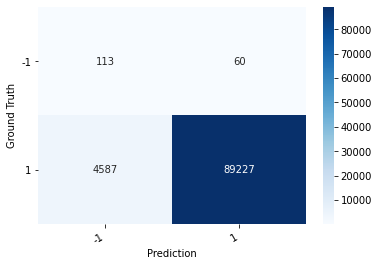

In [ ]:
show_confusion_matrix(df_cm)

# Local Outlier Factor With Subsampling

What about subsampling on dominant class? Will this helpful for us? Let's see.

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [ ]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

Let's subsample normal class (1) with proportion of $\lceil\frac{len(data)}{200}\rceil$.

In [ ]:
n_samples = train_df[train_df["Class"] == 1].shape[0] // 200
anomalies = train_df[train_df["Class"] == -1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 1].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == -1].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

319 952


Now, we have 952 normal and 319 anomaly in our train dataset. Lastly, we will do the same things. Initialize the estimator, fit it, then predict and evaluate.

In [ ]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [ ]:
clfLOF = LocalOutlierFactor(
    n_neighbors=7, 
    metric='l1', 
    algorithm='auto', 
    contamination=0.10,# len(y_train[y_train == -1])/len(y_train[y_train == 1]), 
    n_jobs=-1,
)

In [ ]:
clfLOF.fit(X_train, y_train)

LocalOutlierFactor(contamination=0.1, metric='l1', n_jobs=-1, n_neighbors=7)

In [ ]:
y_pred_test = clfLOF.fit_predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.01      0.75      0.03       173
           1       1.00      0.90      0.95     93814

    accuracy                           0.90     93987
   macro avg       0.51      0.82      0.49     93987
weighted avg       1.00      0.90      0.95     93987



In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

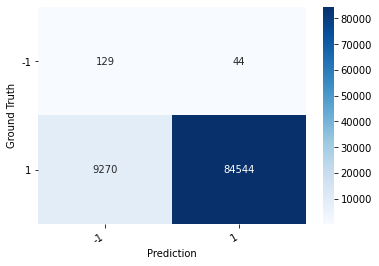

In [ ]:
show_confusion_matrix(df_cm)

# XGBoost

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [ ]:
def lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5,  early_stopping_rounds=50):
    clf = XGBClassifier(
      learning_rate=0.1, 
      n_estimators=140, 
      max_depth=5,
      min_child_weight=3, 
      gamma=0.2, 
      subsample=0.6,
      colsample_bytree=0.6,
      objective='binary:logistic', 
      nthread=4, 
      scale_pos_weight=20, 
      seed=27,
      tree_method = "gpu_hist"
    )

    if useTrainCV:
        print("Started cross-validation...")
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=clf.get_params()['n_estimators'], 
            nfold=cv_folds,
            early_stopping_rounds=early_stopping_rounds
        )
        clf.set_params(n_estimators=cvresult.shape[0])
    print('Started Training...')
    clf.fit(X_train, y_train, eval_metric='auc')

    print("Started Predicting...")
    predictions = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)[:, 1]

    print("\nResulting Metrics")
    print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
    print("AUC : %f" % roc_auc_score(y_test, pred_proba))
    print("F1 Score : %f" % f1_score(y_test, predictions))
    print()
    print(f"{classification_report(y_test, predictions)}")
    print()
    cm = confusion_matrix(y_test, predictions)
    df_cm = pd.DataFrame(
      cm,
      index = ["0","1"], columns=["0","1"]
    )
    show_confusion_matrix(df_cm)
    print()

    feat_imp = clf.feature_importances_
    feat = X_train.columns.tolist()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())
    return clf

In [ ]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Started cross-validation...
Started Training...
Started Predicting...

Resulting Metrics
Accuracy : 0.9996
AUC : 0.985039
F1 Score : 0.875776

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.95      0.82      0.88       173

    accuracy                           1.00     93987
   macro avg       0.97      0.91      0.94     93987
weighted avg       1.00      1.00      1.00     93987





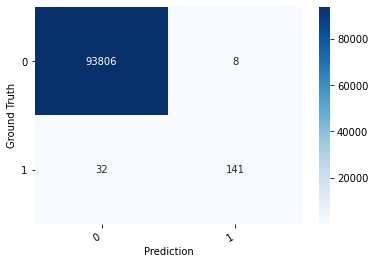

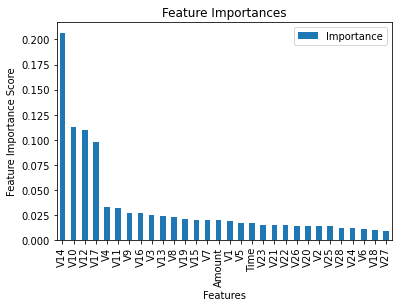

   Features  Importance
14      V14    0.206884
10      V10    0.112688
12      V12    0.109912
17      V17    0.097805
4        V4    0.032179
11      V11    0.031522
9        V9    0.026765
16      V16    0.026674
3        V3    0.024978
13      V13    0.023629
8        V8    0.022582
19      V19    0.020566
15      V15    0.019934
7        V7    0.019934
29   Amount    0.019374
1        V1    0.018434
5        V5    0.016630
0      Time    0.016514
23      V23    0.015023
21      V21    0.014945
22      V22    0.014287
26      V26    0.014155
20      V20    0.014104
2        V2    0.014098
25      V25    0.013489
28      V28    0.011912
24      V24    0.011179
6        V6    0.011123
18      V18    0.009896
27      V27    0.008785
['V14', 'V10', 'V12', 'V17', 'V4', 'V11', 'V9', 'V16', 'V3', 'V13', 'V8', 'V19', 'V15', 'V7', 'Amount', 'V1', 'V5', 'Time', 'V23', 'V21', 'V22', 'V26', 'V20', 'V2', 'V25', 'V28', 'V24', 'V6', 'V18', 'V27']


In [ ]:
clf = lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True)

# XGBoost With Subsampling

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [ ]:
n_samples = train_df[train_df["Class"] == 0].shape[0] // 15
anomalies = train_df[train_df["Class"] == 1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 0].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == 0].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

12700 319


In [ ]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Started cross-validation...
Started Training...
Started Predicting...

Resulting Metrics
Accuracy : 0.9986
AUC : 0.989380
F1 Score : 0.683721

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.57      0.85      0.68       173

    accuracy                           1.00     93987
   macro avg       0.79      0.92      0.84     93987
weighted avg       1.00      1.00      1.00     93987





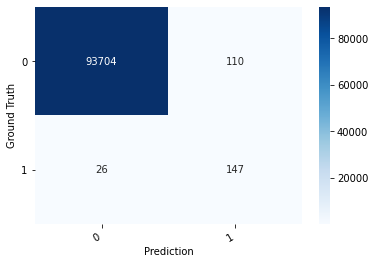

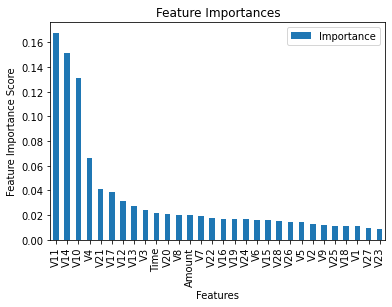

   Features  Importance
11      V11    0.167779
14      V14    0.151345
10      V10    0.130727
4        V4    0.065934
21      V21    0.041173
17      V17    0.038774
12      V12    0.031367
13      V13    0.027234
3        V3    0.024417
0      Time    0.021430
20      V20    0.020741
8        V8    0.020324
29   Amount    0.020023
7        V7    0.019364
22      V22    0.017303
16      V16    0.016987
19      V19    0.016576
24      V24    0.016510
6        V6    0.016197
15      V15    0.015621
28      V28    0.014812
26      V26    0.014585
5        V5    0.014246
2        V2    0.012579
9        V9    0.012082
25      V25    0.011446
18      V18    0.010901
1        V1    0.010754
27      V27    0.009821
23      V23    0.008947
['V11', 'V14', 'V10', 'V4', 'V21', 'V17', 'V12', 'V13', 'V3', 'Time', 'V20', 'V8', 'Amount', 'V7', 'V22', 'V16', 'V19', 'V24', 'V6', 'V15', 'V28', 'V26', 'V5', 'V2', 'V9', 'V25', 'V18', 'V1', 'V27', 'V23']


In [ ]:
clf = lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True)

# Catboost

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [ ]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed = SEED,
    bagging_temperature = 0.2,
    od_type='Iter',
    od_wait=100,
    task_type="GPU",
    verbose=0
)

model.fit(X_train,y_train,eval_set=(X_test,y_test))


Resulting Metrics
Accuracy : 0.9996
AUC : 0.980661
F1 Score : 0.876190

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.97      0.80      0.88       173

    accuracy                           1.00     93987
   macro avg       0.99      0.90      0.94     93987
weighted avg       1.00      1.00      1.00     93987




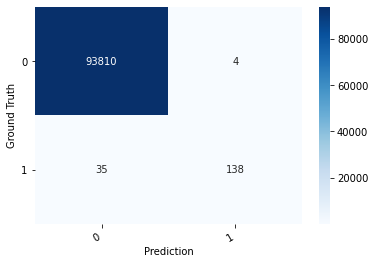

In [ ]:
predictions = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
print("AUC : %f" % roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % f1_score(y_test, predictions))

print()
print(f"{classification_report(y_test, predictions)}")
print()
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(
    cm,
    index = ["0","1"], columns=["0","1"]
)
show_confusion_matrix(df_cm)